<a href="https://colab.research.google.com/github/charlesm93/nested-rhat/blob/main/nRhat_convergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Behavior of $\mathfrak n \widehat R$ on test models

This notebook is intended to present in a reproducible fashion numerical experiments used to evaluate the behavior of $\mathfrak n \widehat R$ across a range of models. Each section can be run independently, once the "setup" section has been run.

This file is an updated version of an original notebook released by Google Research (https://github.com/google-research/google-research/tree/master/nested_rhat, Copyright 2021 Google LLC.)

Revision to this notebook were made by Charles C. Margossian (Copyright 2022 Charles C. Margossian)

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [ ]:
!pip install --upgrade jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install fun_mc.
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!pip install tf-nightly tfp-nightly jax jaxlib

Cloning into 'probability'...
remote: Enumerating objects: 97033, done.
remote: Counting objects: 100% (2036/2036), done.
remote: Compressing objects: 100% (929/929), done.
remote: Total 97033 (delta 1258), reused 1625 (delta 1103), pack-reused 94997
Receiving objects: 100% (97033/97033), 135.40 MiB | 24.40 MiB/s, done.
Resolving deltas: 100% (78439/78439), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 583.9 MB 29 kB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
     |████████████████████████████████| 439 kB 66.6 MB/s 
     |████████████████████████████████| 5.9 MB 75.0 MB/s 
     |████████████████████████████████| 1.7 MB 55.3 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


In [ ]:
!pip install immutabledict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from matplotlib.pyplot import *
# %config InlineBackend.figure_format = 'retina'
# matplotlib.pyplot.style.use("dark_background")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

In [ ]:
# Use this to silence check types warning message 
# (can be removed once next TFP nightly is released)
from absl import logging
logging.set_verbosity(logging.ERROR)
import logging
logging.disable(logging.WARNING)

In [ ]:
import jax
from jax import random
from jax import numpy as jnp

# from colabtools import adhoc_import  # Only needed inside Google

# import tensforflow_datasets
from inference_gym import using_jax as gym

# from tensorflow_probability.spinoffs.fun_mc import using_jax as fun_mcmc
from fun_mc import using_jax as fun_mcmc

# # import tensorflow as tf
from tensorflow_probability.python.internal import prefer_static as ps
from tensorflow_probability.python.internal import unnest


import tensorflow_probability as _tfp
tfp = _tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

tfp_np = _tfp.substrates.numpy
tfd_np = tfp_np.distributions

import arviz as az
from tensorflow_probability.python.internal.unnest import get_innermost


In [ ]:
print(jax.__version__)

0.3.17


In [ ]:
# Import the inverse CDF for a Gaussian
# CHECK: can this be done with TFP?
from scipy.stats import norm
from scipy.stats import f

In [ ]:
# Plotting tools
import seaborn as sns

In [ ]:
# Packages to save files on the google drive
from google.colab import files
from google.colab import drive

drive.mount('/content/gdrive')

dir_name = "gdrive/MyDrive/nRhat_experiments/"

Mounted at /content/gdrive


# Application to models

## Setup

### Nested $\hat R$

In [ ]:
# Define nested Rhat for one parameter.
# This assumes the indexed parameter is a scalar, hence the result_state
# tensor needs to be formatted accordingly.
# TODO: deprecate state_is_list argument
def nested_rhat_1dim(result_state, num_super_chains, index_param, 
                     num_samples, warmup_length = 0,
                     rank_normalize = False):
                     # state_is_list = False, vector_index = None):

  # The below code is DEPRECATED
  # if state_is_list:
  #   if vector_index is not None:
  #     state_param = result_state[index_param][
  #                 warmup_length:(warmup_length + num_samples), :, vector_index]
  #   else:
  #     state_param = result_state[index_param][
  #                       warmup_length:(warmup_length + num_samples), :]
  # else:
  #   state_param = result_state[warmup_length:(warmup_length + num_samples),
  #                              :, index_param]

  state_param = result_state[warmup_length:(warmup_length + num_samples),
                             :, index_param]

  num_samples = state_param.shape[0]
  num_chains = state_param.shape[1]
  num_sub_chains = num_chains // num_super_chains
  total_samples = num_samples * num_chains

  if (rank_normalize):
    state_param_flat = np.reshape(state_param, (total_samples, ))
    temp = state_param_flat.argsort()
    ranks = temp.argsort() + 1
    z = norm.ppf((ranks - 3 / 8) / (total_samples + 1 / 4))
    state_parm = np.reshape(z, (num_samples, num_chains))

  state_param = state_param.reshape(num_samples, -1, num_sub_chains, 1)

  mean_chain = np.mean(state_param, axis = (0, 3))
  between_chain_var = np.var(mean_chain, axis = 1, ddof = 1)
  if (num_samples == 1):
    mean_within_chain_var = 0
  else:
    within_chain_var = np.var(state_param, axis = (0, 3), ddof = 1)
    mean_within_chain_var = np.mean(within_chain_var, axis = 1)

  total_chain_var = between_chain_var + mean_within_chain_var

  mean_super_chain = np.mean(state_param, axis = (0, 2, 3))
  between_super_chain_var = np.var(mean_super_chain, ddof = 1)

  return np.sqrt(1 + between_super_chain_var / np.mean(total_chain_var)),\
    between_super_chain_var, np.mean(total_chain_var)


def nested_rhat(result_state, num_super_chains, index_param, 
                num_samples, warmup_length = 0, rank_normalize = False):
  nRhat = np.array([])
  B = np.array([])
  W = np.array([])
  for i in range(0, index_param.shape[0]):
    nRhat_local, B_local, W_local = nested_rhat_1dim(result_state, 
                    num_super_chains, index_param[i], num_samples,
                    warmup_length, rank_normalize)

    nRhat = np.append(nRhat, nRhat_local)
    B = np.append(B, B_local)
    W = np.append(W, W_local)

  return nRhat, B, W

    # Code for list is DEPRECATED
    # if state_is_list:
    #   shape_state = result_state[index_param[i]].shape
    #   if (len(shape_state) == 2):  # Listed parameter isn't a vector
    #     nRhat_local, B_local, W_local = nested_rhat_1dim(result_state, 
    #                      num_super_chains, index_param[i], num_samples,
    #                      warmup_length, rank_normalize)

    #     nRhat = np.append(nRhat, nRhat_local)
    #     B = np.append(B, B_local)
    #     W = np.append(W, W_local)

    #   else:  # Listed parameter is a vector
    #     for j in range(0, shape_state[2]):
    #       nRhat_local, B_local, W_local = nested_rhat_1dim(result_state,
    #                        num_super_chains, index_param[i], num_samples,
    #                        warmup_length, state_is_list, 
    #                        vector_index = j)

    #       nRhat = np.append(nRhat, nRhat_local)
    #       B = np.append(B, B_local)
    #       W = np.append(W, W_local)


### Run fits

In [ ]:
def construct_kernel(target_log_prob_fn, init_step_size, num_warmup):
  kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn, init_step_size, 1)
  kernel = tfp.experimental.mcmc.GradientBasedTrajectoryLengthAdaptation(kernel, num_warmup)
  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
      kernel, num_warmup, target_accept_prob = 0.75,
      reduce_fn = tfp.math.reduce_log_harmonic_mean_exp)
  return kernel


In [ ]:
def run_fits(num_seed, total_samples, initialize, kernel,
             num_super_chains, index_param, num_samples, num_warmup,
             rank_normalize = False):
  # TODO: deprecate state_is_list argument.
  # if state_is_list:
  #   initial_state = initialize((2,), key = jax.random.PRNGKey(1))
  #   num_parameters = 0
  #   for j in range(0, index_param.shape[0]):
  #     if len(initial_state[j].shape) == 1: 
  #       num_parameters += 1
  #     else:
  #       num_parameters += initial_state[j].shape[1]
  # else:
  num_parameters = index_param.shape[0]

  Rhat_list = np.zeros((num_seed, num_parameters))
  nRhat_list = np.zeros((num_seed, num_parameters))
  B_list = np.zeros((num_seed, num_parameters))
  W_list = np.zeros((num_seed, num_parameters))
  mc_mean_list = np.zeros((num_seed, num_parameters))

  i = 0
  for seed in jax.random.split(jax.random.PRNGKey(1), num_seed):
    initial_state = initialize((num_super_chains,), key = seed + 1954)

    initial_state = np.repeat(initial_state, num_chains // num_super_chains,
                              axis = 0)

    # if (state_is_list):
    #   for j in range(0, len(initial_state)):
    #     initial_state[j] = np.repeat(initial_state[j],
    #                                  num_chains // num_super_chains, axis = 0)
    # else:
    #   initial_state = np.repeat(initial_state, num_chains // num_super_chains,
    #                             axis = 0)

    result = tfp.mcmc.sample_chain(
      total_samples, initial_state, kernel = kernel,
      seed = seed)

    # Classic Rhat requires at least two samples!
    if (num_samples == 1):
      num_samples_rhat = 2
    else:
      num_samples_rhat = num_samples

    # print("num_samples_rhat:", num_samples_rhat);
    # rhat_samples = result.all_states[num_warmup:(num_warmup + num_samples_rhat), :,
    #                               index_param]
    # print("samples shape", rhat_samples.shape)

    Rhat_list[i, :] = tfp.mcmc.potential_scale_reduction(
                result.all_states[num_warmup:(num_warmup + num_samples_rhat), :,
                                  index_param])

    nRhat_local, B_local, W_local = nested_rhat(result.all_states,
                                   num_super_chains = num_super_chains,
                                   index_param = index_param,
                                   num_samples = num_samples,
                                   warmup_length = num_warmup,
                                   rank_normalize = rank_normalize)

    nRhat_list[i, :] = nRhat_local
    B_list[i, :] = B_local
    W_list[i, :] = W_local

    mc_mean_list[i, :] = np.mean(result.all_states[num_warmup + 1, :,
                                                   index_param],
                        axis = 1)
    i += 1

  return Rhat_list, nRhat_list, B_list, W_list, mc_mean_list


### Adaptive warmup (forge chain)

In [ ]:
# Runs the adapative warmup scheme, and produce MCMC samples.
def forge_chain (kernel_cold, kernel_warm, initial_state, num_super_chains,
                 num_warmup_array, num_samples,
                 target_rhat, max_num_steps, index_param, seed,
                 num_nRhat_comp = 1, rank_normalize = False,
                 alpha_quantile = 1,
                 mean_benchmark = None, var_benchmark = None):
  warmup_is_acceptable = False
  window_iteration = 0
  current_state = initial_state
  kernel_args = None

  squared_err_list = np.array([])
  nrhat_list = np.array([])

  while (not warmup_is_acceptable and window_iteration < max_num_steps):

    # 1) Run MCMC on warmup window.
    result_cold, trace, kernel_args = tfp.mcmc.sample_chain(
        num_results = num_warmup_array[window_iteration],
        current_state = current_state,
        kernel = kernel_cold,
        previous_kernel_results = kernel_args,
        trace_fn = lambda _, pkr: unnest.get_innermost(pkr, 'step_size'),
        return_final_kernel_results = True,
        seed = seed + window_iteration)  # Update seed during while loop

    current_state = result_cold[-1]

    # 2) Generate candidate samples.
    result_warm, trace = tfp.mcmc.sample_chain(
        num_results = num_samples * num_nRhat_comp,
        current_state = current_state,
        kernel = kernel_warm,
        trace_fn = lambda _, pkr: unnest.get_innermost(pkr, 'step_size'),
        previous_kernel_results = kernel_args,
        seed = seed + 999999)

    # 3) Check if candidate samples are acceptable.
    nRhat = np.zeros((index_param.shape[0], num_nRhat_comp))
    for i in range(0, num_nRhat_comp):
      nRhat[:, i], _B, _W = nested_rhat(result_warm[i:((i + 1) * num_samples)],
                                  num_super_chains = num_super_chains,
                                  index_param = index_param,
                                  num_samples = num_samples,
                                  rank_normalize = rank_normalize)

    # nRhat_max = max(np.mean(nRhat, axis = 1))
    nRhat_quantile = np.quantile(np.mean(nRhat, axis = 1), alpha_quantile,
                                 interpolation = "nearest")
    print("nRhat_quantile: (", alpha_quantile, ")" , nRhat_quantile)

    if mean_benchmark is not None:
      mc_mean = np.mean(result_warm[0, :, index_param], axis = 1)
      squared_err = np.square(mc_mean - mean_benchmark[index_param])\
        / var_benchmark[index_param]
      
      squared_err_list = np.append(squared_err_list, squared_err)
      nrhat_list = np.append(nrhat_list, np.mean(nRhat, axis = 1))

      # squared_err = np.square(mc_mean - mean_benchmark[index_max])\
      #                  / var_benchmark[index_max]
      # squared_err_list = np.append(squared_err_list, squared_err)
      # max_nrhat_list = np.append(max_nrhat_list, nRhat_max)

    if (nRhat_quantile < target_rhat): warmup_is_acceptable = True

    window_iteration += 1
    # (WHILE loop ends)

  return result_warm, window_iteration, squared_err_list, nrhat_list


In [ ]:
def run_forge_chain (num_seed, kernel_cold, kernel_warm, initialize,
                     num_super_chains, num_warmup, num_samples,
                     target_rhat, max_num_steps, index_param,
                     num_nRhat_comp = 1, rank_normalize = False,
                     alpha_quantile = 1,
                     mean_benchmark = None, var_benchmark = None,
                     initial_seed = 1):
  mc_mean_list = np.zeros((num_seed, index_param.shape[0]))
  warmup_length = np.zeros(num_seed)

  squared_err_list_all = np.array([])
  nrhat_list_all = np.array([])

  i = 0
  for seed in jax.random.split(jax.random.PRNGKey(initial_seed), num_seed):
    print("NEW SEED")
    initial_state = initialize((num_super_chains,), key = seed + 1954)
    initial_state = np.repeat(initial_state, num_chains // num_super_chains,
                              axis = 0)

    result, window_iteration,\
    squared_err_list, nrhat_list = forge_chain(kernel_cold, kernel_warm,
                                           initial_state, num_super_chains,
                                           num_warmup, num_samples,
                                           target_rhat, max_num_steps,
                                           index_param, seed,
                                           num_nRhat_comp, rank_normalize,
                                           alpha_quantile,
                                           mean_benchmark, var_benchmark)

    warmup_length[i] = sum(num_warmup[:window_iteration])
    mc_mean_list[i, :] = np.mean(result[0, :, index_param],
                        axis = 1)
    
    squared_err_list_all = np.append(squared_err_list_all, squared_err_list)
    nrhat_list_all = np.append(nrhat_list_all, nrhat_list)

    i += 1

  return mc_mean_list, warmup_length, squared_err_list_all, nrhat_list_all

## Threshold for $n \hat R$

For this experiment, we compute $n \hat R$ using `n_samples = 3`, to stabilize estimators. To check if the chain is properly warmed up, we only examine the first sample.

Remark: when `n_samples = 1`, we treat the within-chain variance as 0 (this actually makes it harder to accept convergence!). A suitable lower-bound is discussed below.

In [ ]:
num_chains = 128  # 128, 2048
num_super_chains = 16  # 4
num_sub_chains = num_chains // num_super_chains
num_samples = 5
num_seed = 10

If the chains converged (i.e. they behave as though indepdent from one another), then we expect the effective sample size "reported" by $n \hat R$ to be lower-bounded by the number of chains in each super-chain. This gives us an upper-bound for $n \hat R$:

\begin{eqnarray*}
  u_{n \hat R}  = \sqrt{1 + \frac{1}{M}}.
\end{eqnarray*}

In [ ]:
# Compute a lower bound on nRhat if the chains behave as though independent.
nRhat_upper = np.sqrt(1 + 1 / (num_chains / num_super_chains))
print("Convergence upper bound for nRhat:", nRhat_upper) 

Convergence upper bound for nRhat: 1.0606601717798212


Now let's set things up for the rank-normalize approach.

In [ ]:
rank_normalize = True

When we use rank-normalization and compute $n \hat R$ using the resulting $z$-score, _and_ we only use one sample per iteration, then we expect
$$
\frac{\hat B}{\hat W} \sim \frac{1}{M} F_{K - 1, K(M - 1)}
$$
where $K$ is the number of super-chains and $M$ the number of chains per super-chain.

In [ ]:
upper_quantile = 0.95
alpha_quantile = 0.95
dof1 = num_super_chains - 1
dof2 = num_super_chains * (num_sub_chains - 1)
f_stat = f.ppf(upper_quantile, dof1, dof2) / num_sub_chains
nRhat_upper_f = np.sqrt(1 + f_stat)
print("Convergence upper bound for one-sample nRhat:", nRhat_upper_f)

Convergence upper bound for one-sample nRhat: 1.1043420938798092


In [ ]:
if (rank_normalize):
  nRhat_upper = nRhat_upper_f

Another approach for setting the upper-bound is to think of $n \hat R$ as controlling the variance in expectation, conditional on the initialization, i.e $\text{Var} (\mathbb E (\theta \mid \theta_0)$

In [ ]:
if (True):
  nRhat_upper = 1.01

In [ ]:
# examine the selected criterion
print("nRhat_upper: ", nRhat_upper)

nRhat_upper:  1.01


In [ ]:
# additional parameters for plots (for chi squared coverage)
# NOTE: use 80% coverage (more stable than 95% coverage)
chi_up = 2.705543  # 95th quantile for chi squared with df = 1
chi_lo = 0.01579077  # 05th quantile for chi squared with df = 1

## Banana

In [ ]:
target = gym.targets.VectorModel(gym.targets.Banana(),
                                 flatten_sample_transformations=True)
num_dimensions = target.event_shape[0]  
init_step_size = 1.

def target_log_prob_fn(x):
  """Unnormalized, unconstrained target density.
  
  This is a thin wrapper that applies the default bijectors so that we can
  ignore any constraints.
  """
  y = target.default_event_space_bijector(x)
  fldj = target.default_event_space_bijector.forward_log_det_jacobian(x)
  return target.unnormalized_log_prob(y) + fldj

# NOTE: Avoid initials centered around the true mean. 
offset = 2
def initialize (shape, key = random.PRNGKey(37272709)):
  return 10 * random.normal(key, shape + (num_dimensions,)) + offset

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


In [ ]:
# Get some estimates of the mean and variance.
try:
  mean_est = target.sample_transformations['identity'].ground_truth_mean
except:
  print('no ground truth mean')
  mean_est = (result.all_states[num_warmup:, :]).mean(0).mean(0)
try:
  var_est = target.sample_transformations['identity'].ground_truth_standard_deviation**2
except:
  print('no ground truth std dev')
  var_est = ((result.all_states[num_warmup:, :]**2).mean(0).mean(0) -
             mean_est**2)

In [ ]:
# Define MCMC kernel
# NOTE: to compute classic Rhat, need at least 2 iterations per chain.
# To insure this, total_samples is incremented by 1.
num_warmup, num_samples = 1000, 5
total_samples = num_warmup + num_samples + 1

kernel = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                          init_step_size = init_step_size,
                          num_warmup = num_warmup)

In [ ]:
index_param = np.array([0, 1])

In [ ]:
num_seed = 30

### $n \hat R$ diagnostic

In [ ]:
Rhat_list, nRhat_list, B_list, W_list, mc_mean_list = run_fits(
           num_seed = num_seed, total_samples = total_samples,
           initialize = initialize, kernel = kernel,
           num_super_chains = num_super_chains, index_param = index_param,
           num_samples = num_samples, num_warmup = num_warmup,
           rank_normalize = rank_normalize)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that t

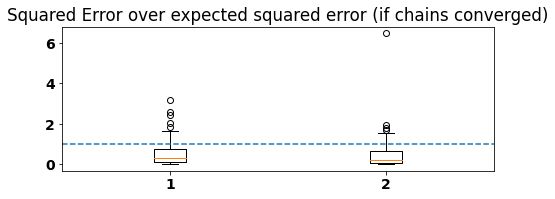

In [ ]:
square_error = np.square(mc_mean_list - mean_est[index_param])
expected_error = var_est[index_param] / num_chains

fig = figure(figsize =(6, index_param.shape[0]))
ax = fig.add_axes([0, 0, 1, 1])
plot_data = [square_error[:, 0] / expected_error[0], 
             square_error[:, 1] / expected_error[1]]
ax.boxplot(plot_data)
axhline(y = 1, linestyle = "--")
title("Squared Error over expected squared error (if chains converged)")
show()

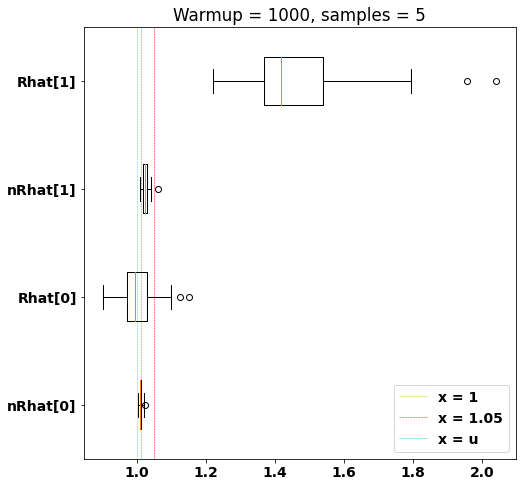

In [ ]:
fig = figure(figsize =(6, 6))
ax = fig.add_axes([0, 0, 1, 1])
plot_data = [nRhat_list[:, 0], Rhat_list[:, 0],
             nRhat_list[:, 1], Rhat_list[:, 1]]
axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
        label = "x = 1")
axvline(x = 1.05, color = 'r', linestyle = '--', linewidth = 0.5,
        label = "x = 1.05")
axvline(x = nRhat_upper, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = u")
ax.boxplot(plot_data, vert = 0)
ax.set_yticklabels(['nRhat[0]', 'Rhat[0]',
                    'nRhat[1]', 'Rhat[1]'])
title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
legend(loc = "best")
show()

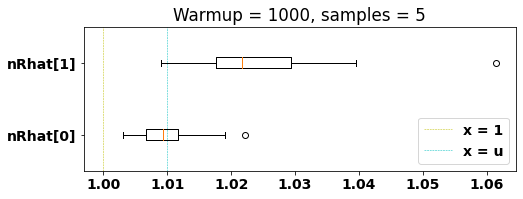

In [ ]:
# Let's take a closer look at the nRhat's and compare them
# to what we would expect from independent samples.
fig = figure(figsize = (6, 2))
ax = fig.add_axes([0, 0, 1, 1])
plot_data = [nRhat_list[:, 0], nRhat_list[:, 1]]
axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
        label = "x = 1")
axvline(x = nRhat_upper, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = u")
ax.boxplot(plot_data, vert = 0)
ax.set_yticklabels(['nRhat[0]', 'nRhat[1]'])
title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
legend(loc = "best")
show()

### Adaptive warmup length

Remark: using a short window gives the algorithm more opportunities to stop, which means start trying our luck. A reasonable compromise seems to use a window of size 100.

In [ ]:
num_seed = 30

To disable the adaptive warmup, i.e. make the chain run until a warmup of 1,000 has been achieved, set `nRhat_upper = 1`, a target which cannot be attained in finite time. 

In [ ]:
dont_adapt_warmup = True
if (dont_adapt_warmup):
  nRhat_upper = 1.

num_samples = 1

In [ ]:
warmup_window = 100
max_warmup = 1000

window_array = np.append(np.repeat(10, 10), 
                      np.repeat(warmup_window, max_warmup // warmup_window - 1))


kernel_cold = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                               init_step_size = init_step_size,
                               num_warmup = max_warmup)

kernel_warm = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                               init_step_size = init_step_size,
                               num_warmup = 0)

num_samples = num_samples

In [ ]:
# check tuning parameters of experiment
print("num_samples", num_samples)
print("num_super_chains", num_super_chains)
print("num_chains", num_chains)
print("num_seed", num_seed)
print("nRhat_upper", nRhat_upper)

num_samples 1
num_super_chains 16
num_chains 128
num_seed 30
nRhat_upper 1.0


In [ ]:
mc_mean_list, warmup_length,\
squared_error_list, nrhat_list = run_forge_chain(num_seed = num_seed,
                                          kernel_cold = kernel_cold,
                                          kernel_warm = kernel_warm,
                                          initialize = initialize,
                                          num_super_chains = num_super_chains,
                                          num_warmup = window_array,
                                          num_samples = num_samples,
                                          target_rhat = nRhat_upper,
                                          max_num_steps = window_array.shape[0],
                                          # max_num_steps = 1000 // warmup_window,
                                          index_param = index_param,
                                          # num_nRhat_comp = 3,
                                          mean_benchmark = mean_est, 
                                          var_benchmark = var_est)


NEW SEED
nRhat_quantile: ( 1 ) 3.886089563369751
nRhat_quantile: ( 1 ) 2.455142021179199
nRhat_quantile: ( 1 ) 1.8751780986785889
nRhat_quantile: ( 1 ) 1.7086423635482788
nRhat_quantile: ( 1 ) 1.6195290088653564
nRhat_quantile: ( 1 ) 1.4882928133010864
nRhat_quantile: ( 1 ) 1.4847713708877563
nRhat_quantile: ( 1 ) 1.3807998895645142
nRhat_quantile: ( 1 ) 1.2964147329330444
nRhat_quantile: ( 1 ) 1.2144731283187866
nRhat_quantile: ( 1 ) 1.0849970579147339
nRhat_quantile: ( 1 ) 1.0607532262802124
nRhat_quantile: ( 1 ) 1.07977294921875
nRhat_quantile: ( 1 ) 1.0473709106445312
nRhat_quantile: ( 1 ) 1.0649691820144653
nRhat_quantile: ( 1 ) 1.0477080345153809
nRhat_quantile: ( 1 ) 1.0630024671554565
nRhat_quantile: ( 1 ) 1.087307095527649
nRhat_quantile: ( 1 ) 1.0799037218093872
NEW SEED
nRhat_quantile: ( 1 ) 3.4399962425231934
nRhat_quantile: ( 1 ) 3.041477918624878
nRhat_quantile: ( 1 ) 2.137415647506714
nRhat_quantile: ( 1 ) 1.8590977191925049
nRhat_quantile: ( 1 ) 1.695268154144287
nRhat_

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef([HashableWeakRef(<weakref at 0x7fe18bb507d0; dead>)])>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/jax/internal/cache_util.py", line 148, in _cleanup
    def _cleanup(self, _):
KeyboardInterrupt


nRhat_quantile: ( 1 ) 1.1961579322814941
nRhat_quantile: ( 1 ) 1.1813935041427612


In [ ]:
square_error = np.square(mc_mean_list - mean_est[index_param])
expected_error = var_est[index_param] / num_chains

plot_data = [square_error[:, 0] / expected_error[0]]
for i in range(1, index_param.shape[0]):
  plot_data.append(square_error[:, i] / expected_error[i])

fig = figure(figsize =(6, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(plot_data)
axhline(y = 1, linestyle = "--")
axhline(y = chi_up)   # 90th quantile for chi squared with df = 1
axhline(y = chi_lo) # 5th quantile for chi squared with df = 1 
title("Squared Error over expected squared error (if chains converged)")
show()

In [ ]:
# NOTE: if rhat_upper = 1, will always hit iter = 1000
scatter(warmup_length, square_error[:, 0] / expected_error[0], alpha = 0.5)
axhline(y = 1, linestyle = "--")
axhline(y = chi_up)   # 90th quantile for chi squared with df = 1
axhline(y = chi_lo) # 5th quantile for chi squared with df = 1 
show()

In [ ]:
scatter(nrhat_list - 1, squared_error_list, alpha = 0.5)
axvline(x = nRhat_upper - 1, linestyle = "--")
xscale('log')
yscale('log')
axhline(y = 1 / num_chains, color = 'black')
axhline(y = chi_up / num_chains, color = 'black', linestyle = '--')
axhline(y = chi_lo / num_chains, color = 'black', linestyle = '--')

In [ ]:
nrhat_list.shape[0]

In [ ]:
num_super_chains

In [ ]:
# Save output into npy files on gdrive
model_name = "banana"

np.save(dir_name + model_name + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_max_nrhat", nrhat_list)
np.save(dir_name + model_name + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_squared_error", squared_error_list)

## German credit score

In [ ]:
target = gym.targets.VectorModel(gym.targets.GermanCreditNumericLogisticRegression(),
                                  flatten_sample_transformations=True)
num_dimensions = target.event_shape[0]  
init_step_size = 0.02

def target_log_prob_fn(x):
  """Unnormalized, unconstrained target density.
  
  This is a thin wrapper that applies the default bijectors so that we can
  ignore any constraints.
  """
  y = target.default_event_space_bijector(x)
  fldj = target.default_event_space_bijector.forward_log_det_jacobian(x)
  return target.unnormalized_log_prob(y) + fldj

offset = 0.5
def initialize (shape, key = random.PRNGKey(37272709)):
  return 3 * random.normal(key, shape + (num_dimensions,)) + offset

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


In [ ]:
# Get some estimates of the mean and variance.
try:
  mean_est = target.sample_transformations['identity'].ground_truth_mean
except:
  print('no ground truth mean')
  mean_est = (result.all_states[num_warmup:, :]).mean(0).mean(0)
try:
  var_est = target.sample_transformations['identity'].ground_truth_standard_deviation**2
except:
  print('no ground truth std dev')
  var_est = ((result.all_states[num_warmup:, :]**2).mean(0).mean(0) -
             mean_est**2)

In [ ]:
num_seed = 10
num_warmup, num_samples = 500, 5
total_samples = num_warmup + num_samples + 1

kernel = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                          init_step_size = init_step_size,
                          num_warmup = num_warmup)

In [ ]:
index_param = np.arange(0, 25)

### $n \hat R$ diagnostic

In [ ]:
Rhat_list, nRhat_list, B_list, W_list, mc_mean_list = run_fits(
           num_seed = num_seed, total_samples = total_samples,
           initialize = initialize, kernel = kernel,
           num_super_chains = num_super_chains, index_param = index_param,
           num_samples = num_samples, num_warmup = num_warmup,
           rank_normalize = rank_normalize)

In [ ]:
# OPTIONAL: correct Rhat to avoid having negative values.
if True:
  Rhat_list = np.sqrt(np.square(Rhat_list) - (num_samples - 1) / num_samples + 1)

In [ ]:
square_error = np.square(mc_mean_list - mean_est[index_param])
expected_error = var_est[index_param] / num_chains

plot_data = [square_error[:, 0] / expected_error[0]]
for i in range(1, index_param.shape[0]):
  plot_data.append(square_error[:, i] / expected_error[i])

fig = figure(figsize =(6, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(plot_data)
axhline(y = 1, linestyle = "--")
axhline(y = chi_up)   # 90th quantile for chi squared with df = 1
axhline(y = chi_lo) # 5th quantile for chi squared with df = 1
title("Squared Error over expected squared error (if chains converged)")
show()

In [ ]:
plot_data = [nRhat_list[:, 0], Rhat_list[:, 0]]
ylabels = ['nRhat[0]', 'Rhat[0]']
plot_data_nRhat = [nRhat_list[:, 0]]
ylabels_nRhat = ['nRhat[0]']
for i in range(1, index_param.shape[0]):
  plot_data.append(nRhat_list[:, i])
  plot_data.append(Rhat_list[:, i])
  ylabels.append(('nRhat[' + str(i) + ']'))
  ylabels.append(('Rhat[' + str(i) + ']'))

  plot_data_nRhat.append(nRhat_list[:, i])
  ylabels_nRhat.append(('nRhat[' + str(i) + ']'))


In [ ]:
fig = figure(figsize =(6, 0.5 * index_param.shape[0]))
ax = fig.add_axes([0, 0, 1, 1])
axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
        label = "x = 1")
axvline(x = 1.05, color = 'r', linestyle = '--', linewidth = 0.5,
        label = "x = 1.05")
axvline(x = nRhat_upper, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = u")
ax.boxplot(plot_data, vert = 0)
ax.set_yticklabels(ylabels)
title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
legend(loc = "best")
show()

In [ ]:
# Let's take a closer look at the nRhat's and compare them
# to what we would expect from independent samples.
fig = figure(figsize =(6, 0.5 * index_param.shape[0]))
ax = fig.add_axes([0, 0, 1, 1])
axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
        label = "x = 1")
axvline(x = nRhat_upper, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = u")
ax.boxplot(plot_data_nRhat, vert = 0)
ax.set_yticklabels(ylabels_nRhat)
title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
legend(loc = "best")
show()

### Adapative warmup length

In [ ]:
warmup_window = 100
max_warmup = 1000

window_array = np.append(np.repeat(10, 10), 
                      np.repeat(warmup_window, max_warmup // warmup_window - 1))


kernel_cold = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                               init_step_size = init_step_size,
                               num_warmup = max_warmup)

kernel_warm = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                               init_step_size = init_step_size,
                               num_warmup = 0)

num_seed = 10
nRhat_upper = 1 +  0.05  # no warmup early ending if set to 1
alpha_quantile = 1
num_samples = 5

In [ ]:
# Check the tuning parameters of the experiment
print("num_samples: ", num_samples)
print("nRhat_upper: ", nRhat_upper)
print("num_seed: ", num_seed)
print("num_super_chains:", num_super_chains)
print("num_sub_chains:", num_sub_chains)

num_samples:  5
nRhat_upper:  1.05
num_seed:  10
num_super_chains: 16
num_sub_chains: 8


In [ ]:
mc_mean_list, warmup_length,\
squared_error_list, max_nrhat_list = run_forge_chain(num_seed = num_seed,
                                  kernel_cold = kernel_cold,
                                  kernel_warm = kernel_warm,
                                  initialize = initialize,
                                  num_super_chains = num_super_chains,
                                  num_warmup = window_array,
                                  num_samples = num_samples,
                                  target_rhat = nRhat_upper,
                                  max_num_steps = window_array.shape[0],
                                  # max_num_steps = max_warmup // warmup_window,
                                  index_param = index_param,
                                  num_nRhat_comp = 1,
                                  rank_normalize = rank_normalize,
                                  alpha_quantile = alpha_quantile,
                                  mean_benchmark = mean_est,
                                  var_benchmark = var_est)


NEW SEED
nRhat_quantile: ( 1 ) 5.476095199584961
nRhat_quantile: ( 1 ) 4.442435264587402
nRhat_quantile: ( 1 ) 3.8192873001098633
nRhat_quantile: ( 1 ) 3.410398006439209
nRhat_quantile: ( 1 ) 3.018731117248535
nRhat_quantile: ( 1 ) 2.5969598293304443
nRhat_quantile: ( 1 ) 2.1592366695404053
nRhat_quantile: ( 1 ) 1.8633861541748047
nRhat_quantile: ( 1 ) 1.6518861055374146
nRhat_quantile: ( 1 ) 1.535868763923645
nRhat_quantile: ( 1 ) 1.092092514038086
nRhat_quantile: ( 1 ) 1.083252191543579
nRhat_quantile: ( 1 ) 1.0851657390594482
nRhat_quantile: ( 1 ) 1.1052576303482056
nRhat_quantile: ( 1 ) 1.0721015930175781
nRhat_quantile: ( 1 ) 1.0216498374938965
NEW SEED
nRhat_quantile: ( 1 ) 4.623876094818115
nRhat_quantile: ( 1 ) 4.844254016876221
nRhat_quantile: ( 1 ) 3.7532033920288086
nRhat_quantile: ( 1 ) 3.3766391277313232
nRhat_quantile: ( 1 ) 3.01442813873291
nRhat_quantile: ( 1 ) 2.5341339111328125
nRhat_quantile: ( 1 ) 2.159726619720459
nRhat_quantile: ( 1 ) 1.9178146123886108
nRhat_quan

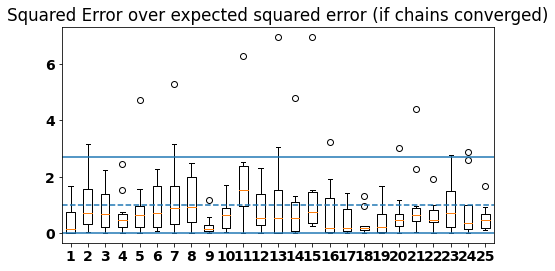

In [ ]:
square_error = np.square(mc_mean_list - mean_est[index_param])
expected_error = var_est[index_param] / num_chains

plot_data = [square_error[:, 0] / expected_error[0]]
for i in range(1, index_param.shape[0]):
  plot_data.append(square_error[:, i] / expected_error[i])

fig = figure(figsize =(6, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(plot_data)
axhline(y = 1, linestyle = "--")
axhline(y = chi_up)   # 90th quantile for chi squared with df = 1
axhline(y = chi_lo) # 10th quantile for chi squared with df = 1
title("Squared Error over expected squared error (if chains converged)")
show()

In [ ]:
german_scaled_error = square_error / expected_error
german_warmup_length = warmup_length

Text(0.5, 0, 'warmup length')

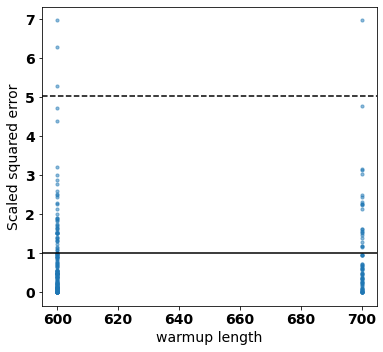

In [ ]:
figure(figsize = [6, 5.5])
for i in range(1, num_dimensions):
  scatter(german_warmup_length, german_scaled_error[:, i], color = 'tab:blue',
          s = 10, alpha = 0.5)
axhline(y = 1, color = 'black')
axhline(y = 5.023886, color = 'black', linestyle = '--')
ylabel("Scaled squared error")
xlabel("warmup length")

In [ ]:
num_super_chains

In [ ]:
# Save output into npy files on gdrive
model_name = "german"

np.save(dir_name + "german" + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples)  + "_max_nrhat.npy", max_nrhat_list)
np.save(dir_name + "german" + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples)  + "_squared_error.npy", squared_error_list)

### Draft

In [ ]:
seed = jax.random.PRNGKey(1954)
initial_state = initialize((num_super_chains,), key = seed + 1954)
initial_state = np.repeat(initial_state, num_chains // num_super_chains,
                          axis = 0)
current_state = initial_state
kernel_args = None

In [ ]:
num_warmup = 250

In [ ]:
result_cold, trace0, kernel_args = tfp.mcmc.sample_chain(
        num_results = num_warmup,
        current_state = current_state,
        kernel = kernel_cold,
        previous_kernel_results = kernel_args,
        trace_fn = lambda _, pkr: unnest.get_innermost(pkr, 'step_size'),
        return_final_kernel_results = True,
        seed = seed)  # Update seed during while loop

current_state = result_cold[-1]


In [ ]:
plot(trace0)

In [ ]:
result_cold, trace1, kernel_args = tfp.mcmc.sample_chain(
        num_results = num_warmup,
        current_state = current_state,
        kernel = kernel_cold,
        previous_kernel_results = kernel_args,
        trace_fn = lambda _, pkr: unnest.get_innermost(pkr, 'step_size'),
        return_final_kernel_results = True,
        seed = seed)  # Update seed during while loop

current_state = result_cold[-1]

In [ ]:
plot(trace1)

In [ ]:
result_warm, trace = tfp.mcmc.sample_chain(
        num_results = num_samples,
        current_state = current_state,
        kernel = kernel_warm,
        trace_fn = lambda _, pkr: unnest.get_innermost(pkr, 'step_size'),
        previous_kernel_results = kernel_args,
        seed = seed + 999999)

In [ ]:
nRhat, _B, _W = nested_rhat(result_warm, num_super_chains, index_param, num_samples)
nRhat

## Eight Schools

In [ ]:
# NOTE: inference gym stores the centered parameterization
target_raw = gym.targets.EightSchools()  # store raw to examine doc.
target = gym.targets.VectorModel(target_raw,
                                  flatten_sample_transformations = True)
num_dimensions = target.event_shape[0]
init_step_size = 1

# Using underdispersed initis can show case problems with our diagnostics.
# underdispered = False
# Options: underdispersed, overdispersed, prior
init_type = "prior"
if init_type == "underdispersed":
  offset = 0.0
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 1 * random.normal(key, shape + (num_dimensions,)) + offset
elif init_type == "overdispersed":
  offset = 0.0
  def initialize (shape, key = random.PRNGKey(37272709)):
    return 100 * random.normal(key, shape + (num_dimensions,)) + offset
elif init_type == "prior":
  def initialize (shape, key = random.PRNGKey(37272709)):
    prior_scale = jnp.append(jnp.array([10., 1.]), jnp.repeat(1., 8))
    prior_offset = jnp.append(jnp.array([0., 5.]), jnp.repeat(0., 8))
    return prior_scale * random.normal(key, shape + (num_dimensions,)) + prior_offset


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


In [ ]:
num_schools = 8
y = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype = np.float32)
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype = np.float32)

# NOTE: the reinterpreted batch dimension specifies the dimension of
# each indepdent variable, here the school.
model = tfd.JointDistributionSequential([
    tfd.Normal(loc = 0., scale = 10., name = "mu"),
    tfd.Normal(loc = 5., scale = 1., name = "log_tau"),
    tfd.Independent(tfd.Normal(loc = jnp.zeros(num_schools),
                               scale = jnp.ones(num_schools),
                               name = "eta"),
                    reinterpreted_batch_ndims = 1),
    lambda eta, log_tau, mu: (
        tfd.Independent(tfd.Normal(loc = (mu[..., jnp.newaxis] +
                                        jnp.exp(log_tau[..., jnp.newaxis]) *
                                        eta),
                                   scale = sigma),
                        name = "y",
                        reinterpreted_batch_ndims = 1))
  ])

def target_log_prob_fn(x):
  mu = x[:, 0]
  log_tau = x[:, 1]
  eta = x[:, 2:10]
  return model.log_prob((mu, log_tau, eta, y))


In [ ]:
# Use results from running 128 chains with 1000 + 5000 iterations each,
# for non-centered parameterization.
mean_est = np.array([5.8006573 ,  2.4502006 ,  0.6532423 ,  0.09639207,
             -0.23725411,  0.04723661, -0.33556408, -0.19666635,
              0.5390533 ,  0.14633301])

var_est = np.array([29.60382   ,  0.26338503,  0.6383733 ,  0.4928926 ,
              0.65307987,  0.52441144,  0.46658015,  0.5248887 ,
              0.49544162,  0.690975])

In [ ]:
index_param = np.arange(0, 10)

### $n \hat R$ diagnostic

In [ ]:
num_seed = 10
num_samples = 5
num_warmup, num_sampling = 1000, 5
total_samples = num_warmup + num_sampling

kernel = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                          init_step_size = init_step_size,
                          num_warmup = num_warmup)


In [ ]:
Rhat_list, nRhat_list, B_list, W_list, mc_mean_list = run_fits(
           num_seed = num_seed, total_samples = total_samples,
           initialize = initialize, kernel = kernel,
           num_super_chains = num_super_chains, index_param = index_param,
           num_samples = num_samples, num_warmup = num_warmup)

In [ ]:
# OPTIONAL: correct Rhat to avoid having negative values.
if True:
  Rhat_list = np.sqrt(np.square(Rhat_list) - (num_samples - 1) / num_samples + 1)

In [ ]:
square_error = np.square(mc_mean_list - mean_est[index_param])
expected_error = var_est[index_param] / num_chains

plot_data = [square_error[:, 0] / expected_error[0]]
for i in range(1, index_param.shape[0]):
  plot_data.append(square_error[:, i] / expected_error[i])

fig = figure(figsize =(6, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(plot_data)
axhline(y = 1, linestyle = "--")
title("Squared Error over expected squared error (if chains converged)")
show()

In [ ]:
# plot_data = [nRhat_list[:, 0], Rhat_list[:, 0]]
# ylabels = ['nRhat[0]', 'Rhat[0]']
plot_data = [nRhat_list[:, 0] - 1]
ylabels = ['0']
plot_data_nRhat = [nRhat_list[:, 0] - 1]
ylabels_nRhat = ['0']
for i in range(1, index_param.shape[0]):
  plot_data.append(nRhat_list[:, i] - 1)
  # plot_data.append(Rhat_list[:, i])
  # ylabels.append('')
  ylabels.append((str(i)))
  # ylabels.append(('Rhat[' + str(i) + ']'))

for i in range(0, index_param.shape[0]):
  plot_data.append(Rhat_list[:, i])
  # ylabels.append('')
  ylabels.append((str(i)))

  plot_data_nRhat.append(nRhat_list[:, i])
  ylabels_nRhat.append((str(i)))

# ylabels[5] = "$n \hat R$  5"
# ylabels[15] = "$\hat R$  5"

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [ ]:
fig, ax = subplots(2, 1, sharey = True, sharex = True, figsize=(6, 5))
# fig = figure(figsize =(6, 0.5 * index_param.shape[0]))
# ax = fig.add_axes([0, 0, 1, 1])
# axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
#         label = "x = 1")
ax[0].axvline(x = nRhat_upper - 1, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = 0.01")
ax[0].axvline(x = .05, color = 'r', linestyle = '--', linewidth = 0.5,
        label = "x = 0.05")

ax[1].axvline(x = nRhat_upper - 1, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = 0.01")
ax[1].axvline(x = .05, color = 'r', linestyle = '--', linewidth = 0.5,
        label = "x = 0.05")

ax[0].boxplot(plot_data[0:10], vert = 0)
ax[1].boxplot(plot_data[10:20], vert = 0)
ax[0].set_yticklabels(ylabels)
# title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
# ax[0].title('$n \hat R$')
ax[0].legend(loc = "upper right")
xscale('log')
xlabel('$\hat R$ ($n\hat R$) - 1')
# ax.set_ylabel('Parameter Index')
fig.text(0.06, 0.5, 'Parameter index', ha='center', va='center', rotation='vertical')
fig.text(0.17, 0.85, '$n \hat R$', ha='center', va = 'center')
fig.text(0.17, 0.43, '$\hat R$', ha='center', va = 'center')

show()

In [ ]:
# Let's take a closer look at the nRhat's and compare them
# to what we would expect from independent samples.
fig = figure(figsize =(6, 0.5 * index_param.shape[0]))
ax = fig.add_axes([0, 0, 1, 1])
axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
        label = "x = 1")
axvline(x = nRhat_upper, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = u")
axvline(x = 1.05, color = 'r', linestyle = '--', linewidth = 0.5,
        label = "x = 1.05")
ax.boxplot(plot_data_nRhat, vert = 0)
ax.set_yticklabels(ylabels_nRhat)
title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
legend(loc = "best")
show()

### Adapative warmup length

In [ ]:
num_seed = 30

In [ ]:
warmup_window = 100
max_warmup = 1000
alpha_quantile = 1  # One of the directions is more difficult than the others,
                    # so we want to address it.

window_array = np.append(np.repeat(10, 10), 
                      np.repeat(warmup_window, max_warmup // warmup_window - 1))

# window_array = np.repeat(warmup_window, max_warmup // warmup_window)

kernel_cold = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                               init_step_size = init_step_size,
                               num_warmup = max_warmup)

kernel_warm = construct_kernel(target_log_prob_fn = target_log_prob_fn,
                               init_step_size = init_step_size,
                               num_warmup = 0)

num_samples = 5  # 1
nRhat_upper = 1.05  # 1

In [ ]:
# Check tuning parameters of the experiment
print("num_samples:", num_samples)
print("num_seed:", num_seed)
print("nRhat_upper:", nRhat_upper)
print("num_super_chains:", num_super_chains)
print("num_sub_chains:", num_sub_chains)

num_samples: 5
num_seed: 30
nRhat_upper: 1.05
num_super_chains: 16
num_sub_chains: 8


In [ ]:
mc_mean_list, warmup_length,\
squared_error_list, max_nrhat_list = run_forge_chain(num_seed = num_seed,
                                          kernel_cold = kernel_cold,
                                          kernel_warm = kernel_warm,
                                          initialize = initialize,
                                          num_super_chains = num_super_chains,
                                          num_warmup = window_array,
                                          num_samples = num_samples,
                                          target_rhat = nRhat_upper,
                                          max_num_steps = window_array.shape[0],
                                          # max_num_steps = max_warmup // warmup_window,
                                          index_param = index_param,
                                          rank_normalize = rank_normalize,
                                          alpha_quantile = alpha_quantile,
                                          mean_benchmark = mean_est,
                                          var_benchmark = var_est)


NEW SEED
nRhat_quantile: ( 1 ) 4.360945224761963
nRhat_quantile: ( 1 ) 2.8930654525756836
nRhat_quantile: ( 1 ) 2.3415937423706055
nRhat_quantile: ( 1 ) 2.0539066791534424
nRhat_quantile: ( 1 ) 1.7788161039352417
nRhat_quantile: ( 1 ) 1.6936510801315308
nRhat_quantile: ( 1 ) 1.5917143821716309
nRhat_quantile: ( 1 ) 1.5765116214752197
nRhat_quantile: ( 1 ) 1.4773215055465698
nRhat_quantile: ( 1 ) 1.4063838720321655
nRhat_quantile: ( 1 ) 1.1411250829696655
nRhat_quantile: ( 1 ) 1.0485228300094604
NEW SEED
nRhat_quantile: ( 1 ) 7.87739372253418
nRhat_quantile: ( 1 ) 5.182034492492676
nRhat_quantile: ( 1 ) 4.072463512420654
nRhat_quantile: ( 1 ) 3.566610097885132
nRhat_quantile: ( 1 ) 3.163635015487671
nRhat_quantile: ( 1 ) 2.741208553314209
nRhat_quantile: ( 1 ) 2.47914719581604
nRhat_quantile: ( 1 ) 2.25793194770813
nRhat_quantile: ( 1 ) 2.0952703952789307
nRhat_quantile: ( 1 ) 1.995022177696228
nRhat_quantile: ( 1 ) 1.3233740329742432
nRhat_quantile: ( 1 ) 1.105519413948059
nRhat_quanti

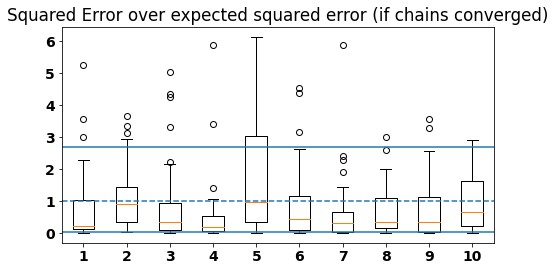

In [ ]:
square_error = np.square(mc_mean_list - mean_est[index_param])
expected_error = var_est[index_param] / num_chains

plot_data = [square_error[:, 0] / expected_error[0]]
for i in range(1, index_param.shape[0]):
  plot_data.append(square_error[:, i] / expected_error[i])

fig = figure(figsize =(6, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(plot_data)
axhline(y = 1, linestyle = "--")
axhline(y = chi_up)   # 90th quantile for chi squared with df = 1
axhline(y = chi_lo) # 10th quantile for chi squared with df = 1

title("Squared Error over expected squared error (if chains converged)")
show()

In [ ]:
square_error_flat = square_error.reshape((num_seed * 10, ))
scaled_square_error = square_error / expected_error
warmup_length_flat = np.repeat(warmup_length, num_seed)

In [ ]:
warmup_length.shape

(30,)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

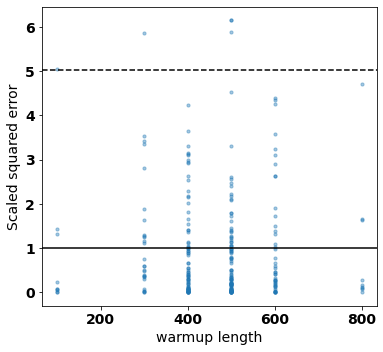

In [ ]:
# scatter(warmup_length, square_error[:, 0] / expected_error[0])
figure(figsize = [6, 5.5])
for i in range(1, 10):
  scatter(warmup_length, scaled_square_error[:, i], color = 'tab:blue',
          s = 10, alpha = 0.4)
axhline(y = 1, color = 'black')
axhline(y = 5.023886, color = 'black', linestyle = '--')
ylabel("Scaled squared error")
xlabel("warmup length")

# show()
savefig("warmup_error.pdf")
files.download("warmup_error.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

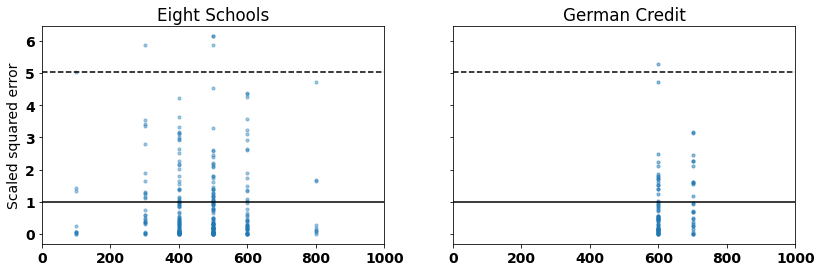

In [ ]:
fig, ax = subplots(1, 2, sharey = True, sharex = True,
                   figsize=(13.5, 4.))
for i in range(1, 10):
  ax[0].scatter(warmup_length, scaled_square_error[:, i], color = 'tab:blue',
          s = 10, alpha = 0.4)
ax[0].axhline(y = 1, color = 'black')
ax[0].axhline(y = 5.023886, color = 'black', linestyle = '--')
ax[0].set(ylabel='Scaled squared error')
ax[0].set(title = "Eight Schools")

for i in range(1, num_dimensions):
  ax[1].scatter(german_warmup_length, german_scaled_error[:, i], color = 'tab:blue',
          s = 10, alpha = 0.5)
ax[1].axhline(y = 1, color = 'black')
ax[1].axhline(y = 5.023886, color = 'black', linestyle = '--')
ax[1].set(title = "German Credit")
xlim(left = 0, right = 1000)

# fig.text(0.5, 0.01, "Adaptive warmup length", ha='center', va='center')

savefig("warmup_error.pdf")
files.download("warmup_error.pdf")

In [ ]:
# Save output into npy files on gdrive
# Data for adaptive warmup is saved using schools_warm (rather than just schools)
model_name = "schools_warm"  #  "schools"

np.save(dir_name + model_name + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_max_nrhat", max_nrhat_list)
np.save(dir_name + model_name + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_squared_error", squared_error_list)

## Pharmacokinetic model

### Simulate data

In [ ]:
time_after_dose = np.array([0.083, 0.167, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 6, 8])

# Use commented out code for 14 dose regime
# t = np.append(
#     np.append(np.append(np.append(0., time_after_dose),
#                           np.append(12., time_after_dose + 12)),
#                np.linspace(start = 24, stop = 156, num = 12)),
#                np.append(jnp.append(168., 168. + time_after_dose),
#                np.array([180, 192])))

t = np.append(
      np.append(
        np.append(0., time_after_dose),
        np.append(12., time_after_dose + 12)),
      np.append(24., time_after_dose + 24)
)

start_event = np.array([], dtype = int)
dosing_time = np.array([0, 12, 24])
# dosing_time = range(0, 192, 12)  # use this for 14 dose regiment

# Use dosing events to determine times of integration between
# exterior interventions on the system.
eps = 1e-4  # hack to deal with some t being slightly offset.
for t_dose in dosing_time:
  start_event = np.append(start_event, np.where(abs(t - t_dose) <= eps))

amt = jnp.array([1000., 0.])
n_dose = start_event.shape[0]

start_event = np.append(start_event, t.shape[0] - 1)

In [ ]:
n_patients = 20  # 100
pop_location = jnp.log(jnp.array([1.5, 0.25]))
pop_scale = jnp.array([0.15, 0.35])
theta_patient = jnp.exp(pop_scale * random.normal(random.PRNGKey(37272709), 
                          (n_patients, ) + (2,)) + pop_location)

amt = np.array([1000., 0.])
amt_patient = np.append(np.repeat(amt[0], n_patients),
                        np.repeat(amt[1], n_patients))
amt_patient = amt_patient.reshape(2, n_patients)

# redfine variables from previous section (in case we only run population model)
t_jax = jnp.array(t)
amt_vec = np.repeat(0., t.shape[0])
amt_vec[start_event] = 1000
amt_vec[amt_vec.shape[0] - 1] = 0.
amt_vec_jax = jnp.array(amt_vec)

In [ ]:
# TODO: remove 'use_second_axis' hack.
def ode_map (theta, dt, current_state, use_second_axis = False):
  if (use_second_axis):
    k1 = theta[0, :]
    k2 = theta[1, :]
  else: 
    k1 = theta[:, 0]
    k2 = theta[:, 1]

  y0_hat = jnp.exp(- k1 * dt) * current_state[0, :]
  y1_hat = jnp.exp(- k2 * dt) / (k1 - k2) * (current_state[0, :] * k1 *\
                (1 - jnp.exp((k2 - k1) * dt)) + (k1 - k2) * current_state[1, :])
  return jnp.array([y0_hat, y1_hat])

# @jax.jit  # Cannot use jit if function has an IF statement.
def ode_map_event(theta, use_second_axis = False):
  def ode_map_step (current_state, event_index):
    dt = t_jax[event_index] - t_jax[event_index - 1]
    y_sln = ode_map(theta, dt, current_state, use_second_axis)
    dose = jnp.repeat(amt_vec_jax[event_index], n_patients)
    y_after_dose = y_sln + jnp.append(jnp.repeat(amt_vec_jax[event_index], n_patients),
                                      jnp.repeat(0., n_patients)).reshape(2, n_patients)
    return (y_after_dose, y_sln[1, ])

  (__, yhat) = jax.lax.scan(ode_map_step, amt_patient, 
                            np.array(range(1, t.shape[0])),
                            unroll = 20)
  return yhat

Text(0, 0.5, 'Mass (mg)')

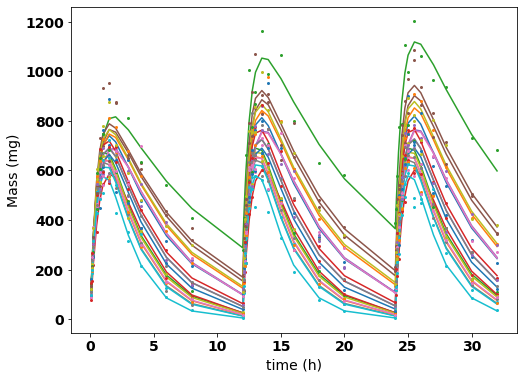

In [ ]:
# Simulate some data
y_hat = ode_map_event(theta_patient)

sigma = 0.1
# NOTE: no observation at time t = 0.
log_y = sigma * random.normal(random.PRNGKey(1954), y_hat.shape) \
  + jnp.log(y_hat)
y_obs = jnp.exp(log_y)

figure(figsize = [8, 6])
plot(t[1:], y_hat)
plot(t[1:], y_obs, 'o', markersize = 2)
xlabel("time (h)")
ylabel("Mass (mg)")
# show()

# savefig("PK_profile.pdf")
# files.download("PK_profile.pdf")

### Fit model with TFP

As a golden benchmark, we use 1,000 samples, after warming up the chain for 1,000 iterations. With 128 chains, this gives us a total of 128,000 approximate samples.

In [ ]:
pop_model = tfd.JointDistributionSequentialAutoBatched([
    tfd.Normal(loc = jnp.log(1.), scale = 0.1, name = "log_k1_pop"),
    tfd.Normal(loc = jnp.log(0.3), scale = 0.1, name = "log_k2_pop"),
    tfd.Normal(loc = jnp.log(0.15), scale = 0.1, name = "log_scale_k1"),
    tfd.Normal(loc = jnp.log(0.35), scale = 0.1, name = "log_scale_k2"),
    tfd.Normal(loc = -1., scale = 1., name = "log_sigma"),

    # non-centered parameterization for hierarchy
    tfd.Independent(tfd.Normal(loc = jnp.zeros(n_patients),
                               scale = jnp.ones(n_patients),
                               name = "eta_k1"),
                    reinterpreted_batch_ndims = 1),
    
    tfd.Independent(tfd.Normal(loc = jnp.zeros(n_patients),
                               scale = jnp.ones(n_patients),
                               name = "eta_k2"),
                    reinterpreted_batch_ndims = 1),

    lambda eta_k2, eta_k1, log_sigma, log_scale_k2, log_scale_k1,
           log_k2_pop, log_k1_pop: (
      tfd.Independent(tfd.LogNormal(
          loc = jnp.log(
              ode_map_event(theta = jnp.array([
                  jnp.exp(log_k1_pop[..., jnp.newaxis] + eta_k1 * jnp.exp(log_scale_k1[..., jnp.newaxis])),
                  jnp.exp(log_k2_pop[..., jnp.newaxis] + eta_k2 * jnp.exp(log_scale_k2[..., jnp.newaxis]))]),
                  use_second_axis = True)),
          scale = jnp.exp(log_sigma[..., jnp.newaxis]), name = "y_obs")))
])

def pop_target_log_prob_fn(log_k1_pop, log_k2_pop, log_scale_k1, log_scale_k2,
                           log_sigma, eta_k1, eta_k2):
  return pop_model.log_prob((log_k1_pop, log_k2_pop, log_scale_k1, log_scale_k2,
                            log_sigma, eta_k1, eta_k2, y_obs))
  # CHECK -- do we need to parenthesis?

def pop_target_log_prob_fn_flat(x):
  log_k1_pop = x[:, 0]
  log_k2_pop = x[:, 1]
  log_scale_k1 = x[:, 2]
  log_scale_k2 = x[:, 3]
  log_sigma = x[:, 4]
  eta_k1 = x[:, 5:(5 + n_patients)]
  eta_k2 = x[:, (5 + n_patients):(5 + 2 * n_patients)]

  return pop_model.log_prob((log_k1_pop, log_k2_pop, log_scale_k1, log_scale_k2,
                           log_sigma, eta_k1, eta_k2, y_obs))


In [ ]:
def initialize (shape, key = random.PRNGKey(37272709)):
  return pop_model.sample(sample_shape = shape, # (num_super_chains, 1),\
                          seed = key)[:7]


In [ ]:
num_dimensions = 5 + 2 * n_patients
def initialize_flat (shape, key = random.PRNGKey(37272709)):
  initial = initialize(shape, key)
  # initial_flat = np.zeros((shape, num_dimensions))
  initial_flat = np.zeros(shape + (num_dimensions,))
  for i in range(0, 5):
    initial_flat[:, i] = initial[i]
  initial_flat[:, 5:(5 + n_patients)] = initial[5]
  initial_flat[:, (5 + n_patients):(5 + 2 * n_patients)] = initial[6]

  return initial_flat


In [ ]:
num_seed = 10
num_samples = 5
num_warmup, num_sampling = 1000, 1000
total_samples = num_warmup + num_sampling
init_step_size = 0.001

kernel = construct_kernel(target_log_prob_fn = pop_target_log_prob_fn,
                          init_step_size = init_step_size,
                          num_warmup = num_warmup)

In [ ]:
def trace_fn(current_state, pkr):
  return (
    # proxy for divergent transitions
    get_innermost(pkr, 'log_accept_ratio') < -1000,
    get_innermost(pkr, 'step_size'),
    get_innermost(pkr, 'max_trajectory_length')
  )


In [ ]:
initial_state = initialize((num_super_chains,))
for i in range(0, len(initial_state)):
  initial_state[i] = np.repeat(initial_state[i],
                               num_chains // num_super_chains, axis = 0)

In [ ]:
mcmc_states, diverged = tfp.mcmc.sample_chain(
    num_results = total_samples,
    current_state = initial_state,
    kernel = kernel,
    trace_fn = trace_fn,
    seed = random.PRNGKey(1954))


In [ ]:
num_chains * num_super_chains

2048

### Check the inference

Check that the inference is reliable. If it, use it to construct a "golden benchmark".

In [ ]:
print("Divergent transitions after warmup:",
      np.sum(diverged[0][num_warmup:(num_warmup + num_samples)]))

Divergent transitions after warmup: 0


In [ ]:
# Extract samples after warmup from the list
mcmc_states_sample = mcmc_states
for i in range(0, len(mcmc_states)):
  mcmc_states_sample[i] = mcmc_states[i][num_warmup:]

In [ ]:
# NOTE: the last parameter is an 'x': not sure where this comes from...
parameter_names = pop_model._flat_resolve_names()[:-1]

az_states = az.from_dict(
    #prior = {k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, mcmc_states)
    },
)

fit_summary = az.summary(az_states).filter(items=["mean", "sd", "mcse_sd", "hdi_3%", 
                                       "hdi_97%", "ess_bulk", "ess_tail", 
                                       "r_hat"])

In [ ]:
fit_summary

,mean,sd,mcse_sd,hdi_3%,hdi_97%,ess_bulk,ess_tail,r_hat
log_k1_pop,0.359,0.033,0.000,0.295,0.419,61026.0,69227.0,1.0
log_k2_pop,-1.308,0.063,0.000,-1.427,-1.188,80472.0,72358.0,1.0
log_scale_k1,-1.915,0.090,0.000,-2.086,-1.749,81919.0,82103.0,1.0
log_scale_k2,-1.023,0.084,0.000,-1.182,-0.867,104757.0,74619.0,1.0
log_sigma,-2.288,0.026,0.000,-2.337,-2.239,79877.0,80900.0,1.0
eta_k1[0],0.976,0.337,0.001,0.343,1.610,79586.0,79335.0,1.0
eta_k1[1],0.420,0.339,0.001,-0.222,1.053,78614.0,75686.0,1.0
eta_k1[2],1.280,0.319,0.001,0.677,1.878,80515.0,82296.0,1.0
eta_k1[3],-1.843,0.351,0.001,-2.498,-1.183,80598.0,81796.0,1.0
eta_k1[4],-1.122,0.352,0.001,-1.799,-0.472,80706.0,78792.0,1.0


In [ ]:
num_dimensions = fit_summary.shape[0]
mean_est = np.zeros(num_dimensions)
var_est = np.zeros(num_dimensions)

for i in range(0, num_dimensions):
  mean_est[i] = fit_summary.iat[i, 0]
  var_est[i] = np.square(fit_summary.iat[i, 1])

In [ ]:
# save benchmark values
model_name = "pk"
if True:
  np.save(dir_name + model_name + "_npatients=" + str(n_patients) + "_mean_est", mean_est)
  np.save(dir_name + model_name + "_npatients=" + str(n_patients) + "_var_est", var_est)

### $n \hat R$ diagnostic

In [ ]:
num_seed = 10
num_samples = 5
num_warmup, num_sampling = 1000, 10
total_samples = num_warmup + num_sampling
init_step_size = 0.001

kernel = construct_kernel(target_log_prob_fn = pop_target_log_prob_fn_flat,
                          init_step_size = init_step_size,
                          num_warmup = num_warmup)

In [ ]:
index_param = np.arange(0, 205)

In [ ]:
Rhat_list, nRhat_list, B_list, W_list, mc_mean_list = run_fits(
           num_seed = num_seed, total_samples = total_samples,
           initialize = initialize_flat, kernel = kernel,
           num_super_chains = num_super_chains, index_param = index_param,
           num_samples = num_samples, num_warmup = num_warmup,
           state_is_list = False)

In [ ]:
# OPTIONAL: correct Rhat to avoid having negative values.
if True:
  Rhat_list = np.sqrt(np.square(Rhat_list) - (num_samples - 1) / num_samples + 1)

In [ ]:
square_error = np.square(mc_mean_list - mean_est[index_param])
expected_error = var_est[index_param] / num_chains

plot_data = [square_error[:, 0] / expected_error[0]]
for i in range(1, index_param.shape[0]):
  plot_data.append(square_error[:, i] / expected_error[i])

fig = figure(figsize =(6, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot(plot_data)
axhline(y = 1, linestyle = "--")
title("Squared Error over expected squared error (if chains converged)")
show()

In [ ]:
plot_data = [nRhat_list[:, 0], Rhat_list[:, 0]]
ylabels = ['nRhat[0]', 'Rhat[0]']
plot_data_nRhat = [nRhat_list[:, 0]]
ylabels_nRhat = ['nRhat[0]']
for i in range(1, index_param.shape[0]):
  plot_data.append(nRhat_list[:, i])
  plot_data.append(Rhat_list[:, i])
  ylabels.append(('nRhat[' + str(i) + ']'))
  ylabels.append(('Rhat[' + str(i) + ']'))

  plot_data_nRhat.append(nRhat_list[:, i])
  ylabels_nRhat.append(('nRhat[' + str(i) + ']'))


In [ ]:
fig = figure(figsize =(6, 0.5 * index_param.shape[0]))
ax = fig.add_axes([0, 0, 1, 1])
axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
        label = "x = 1")
axvline(x = 1.05, color = 'r', linestyle = '--', linewidth = 0.5,
        label = "x = 1.05")
axvline(x = nRhat_upper, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = u")
ax.boxplot(plot_data, vert = 0)
ax.set_yticklabels(ylabels)
title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
legend(loc = "best")
show()

In [ ]:
# Let's take a closer look at the nRhat's and compare them
# to what we would expect from independent samples.
fig = figure(figsize =(6, 0.5 * index_param.shape[0]))
ax = fig.add_axes([0, 0, 1, 1])
axvline(x = 1, color = 'y', linestyle = '--', linewidth = 0.5,
        label = "x = 1")
axvline(x = nRhat_upper, color = 'c', linestyle = '--', linewidth = 0.5,
        label = "x = u")
axvline(x = 1.05, color = 'r', linestyle = '--', linewidth = 0.5,
        label = "x = 1.05")
ax.boxplot(plot_data_nRhat, vert = 0)
ax.set_yticklabels(ylabels_nRhat)
title('Warmup = ' + str(num_warmup) + ', samples = ' + str(num_samples))
legend(loc = "best")
show()

### Adaptive warmup

WARNING: when doing many seeds on the PK model, Colab pro can run out of RAM. To alleviate this issue, reduce the number of seeds, and run the code multiple times, while making sure to change the seed each time.

In [ ]:
num_seed = 10
initial_seed = 1

In [ ]:
n_patients = 20  # alternative is 100

In [ ]:
# Read in benchmark values
model_name = "pk"
mean_est = np.load(dir_name + model_name + "_npatients=" + str(n_patients) + "_mean_est.npy")
var_est = np.load(dir_name + model_name + "_npatients=" + str(n_patients) + "_var_est.npy")

In [ ]:
warmup_window = 100
max_warmup = 1000  # 1000
alpha_quantile = 1
index_param = np.arange(0, 2 * n_patients + 5)

window_array = np.append(np.repeat(10, 10), 
                      np.repeat(warmup_window, max_warmup // warmup_window - 1))

kernel_cold = construct_kernel(target_log_prob_fn = pop_target_log_prob_fn_flat,
                          init_step_size = init_step_size,
                          num_warmup = max_warmup)

kernel_warm = construct_kernel(target_log_prob_fn = pop_target_log_prob_fn_flat,
                          init_step_size = init_step_size,
                          num_warmup = max_warmup)

num_samples = 1
num_super_chains = 64
num_sub_chains = 2
num_chains = num_super_chains * num_sub_chains
nRhat_upper = 1.0  # if set to 1, no early stopping of warmup!

In [ ]:
# Check tuning parameters of the experiment
print("num_seed:", num_seed)
print("num_samples:", num_samples)
print("num_super_chains:", num_super_chains)
print("num_sub_chains:", num_sub_chains)
print("nRhat_upper:", nRhat_upper)

num_seed: 10
num_samples: 1
num_super_chains: 64
num_sub_chains: 2
nRhat_upper: 1.0


In [ ]:
# make sure this defintion uses above number of chains.
initial_state = initialize((num_super_chains,))
for i in range(0, len(initial_state)):
  initial_state[i] = np.repeat(initial_state[i],
                               num_chains // num_super_chains, axis = 0)

In [ ]:
mc_mean_list, warmup_length,\
squared_error_list, max_nrhat_list = run_forge_chain(num_seed = num_seed,
                                          kernel_cold = kernel_cold,
                                          kernel_warm = kernel_warm,
                                          initialize = initialize_flat,
                                          num_super_chains = num_super_chains,
                                          num_warmup = window_array,
                                          num_samples = num_samples,
                                          target_rhat = nRhat_upper,
                                          max_num_steps = window_array.shape[0],
                                          index_param = index_param,
                                          rank_normalize = rank_normalize,
                                          alpha_quantile = alpha_quantile,
                                          mean_benchmark = mean_est,
                                          var_benchmark = var_est,
                                          initial_seed = initial_seed)


NEW SEED


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:282: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


nRhat_quantile: ( 1 ) 26.474990844726562
nRhat_quantile: ( 1 ) 19.854286193847656
nRhat_quantile: ( 1 ) 15.382757186889648
nRhat_quantile: ( 1 ) 15.077476501464844
nRhat_quantile: ( 1 ) 12.83993911743164
nRhat_quantile: ( 1 ) 12.480855941772461
nRhat_quantile: ( 1 ) 11.659984588623047
nRhat_quantile: ( 1 ) 10.518199920654297
nRhat_quantile: ( 1 ) 10.090469360351562
nRhat_quantile: ( 1 ) 10.035378456115723
nRhat_quantile: ( 1 ) 7.289578437805176
nRhat_quantile: ( 1 ) 2.2296853065490723
nRhat_quantile: ( 1 ) 1.3672192096710205
nRhat_quantile: ( 1 ) 1.3537920713424683
nRhat_quantile: ( 1 ) 1.3377279043197632
nRhat_quantile: ( 1 ) 1.4147288799285889
nRhat_quantile: ( 1 ) 1.344817042350769
nRhat_quantile: ( 1 ) 1.4024049043655396
nRhat_quantile: ( 1 ) 1.3229117393493652
NEW SEED
nRhat_quantile: ( 1 ) 36.81067657470703
nRhat_quantile: ( 1 ) 23.22795295715332
nRhat_quantile: ( 1 ) 18.948942184448242
nRhat_quantile: ( 1 ) 18.0913028717041
nRhat_quantile: ( 1 ) 16.295259475708008
nRhat_quantile

In [ ]:
model_name = "pk"  #  "schools"

np.save(dir_name + model_name + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_max_nrhat", max_nrhat_list)
np.save(dir_name + model_name + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_squared_error", squared_error_list)

In [ ]:
# model_name = "pk"

# np.save(dir_name + model_name + "_max_nrhat", max_nrhat_list)
# np.save(dir_name + model_name + "_squared_error", squared_error_list)
# np.save(dir_name + model_name + "_max_nrhat" + "4000", max_nrhat_list)
# np.save(dir_name + model_name + "_squared_error" + "4000", squared_error_list)

## Model synthesis
Generate plots which summarize results across all models.

In [ ]:
# Allows figures to rend latex
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{amsfonts}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [ ]:
from google.colab import files  # use this download saved plots

In [ ]:
num_super_chains = 16 # options: 2, 4, 8, 16, 32, 64
num_chains = 2048  # 128, 2048
num_sub_chains = num_chains // num_super_chains
num_samples = 1
nRhat_upper = 1.01  # Define nRhat_upper (acceptable threshold)

nRhat_lower = np.sqrt(1 + 1 / (num_chains / num_super_chains))

# NOTE: use 80% coverage (more stable than 95% coverage)
chi_up = 3.841459 # 95th quantile for chi squared with df = 1
chi_lo = 0.01579077  # 05th quantile for chi squared with df = 1

# WARNING -- check that the variable definition is consistent with is used
# in experiments. Redefine here so that we don't need to run previous cells.
# TODO: save parameters of the experiment.

print("num_super_chains =", num_super_chains)
print("num_chains =", num_chains)
print("num_samples =", num_samples)
print("nRhat_upper =", nRhat_upper)
print("nRhat_lower =", nRhat_lower)  # only relevant in num_samples = 1!

num_super_chains = 16
num_chains = 2048
num_samples = 1
nRhat_upper = 1.01
nRhat_lower = 1.0038986502630631


In [ ]:
nRhat_banana = np.load(dir_name + "banana" + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_max_nrhat.npy")
err_banana = np.load(dir_name + "banana" + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_squared_error.npy")

nRhat_german = np.load(dir_name + "german" + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_max_nrhat.npy")
err_german = np.load(dir_name + "german" + "_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_squared_error.npy")

nRhat_schools = np.load(dir_name + "schools_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_max_nrhat.npy")
err_schools = np.load(dir_name + "schools_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_squared_error.npy")

nRhat_pk = np.load(dir_name + "pk_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_max_nrhat.npy")
err_pk = np.load(dir_name + "pk_K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + "_squared_error.npy")

# If experiment run over multiple instances (for instance due to
# Colab RAM limit), read in files from each run.
# seed_split = ["10", "100", "1000", "2000", "3000", "4000"]
# for seed_init in seed_split:
#   nRhat_pk = np.append(nRhat_pk, np.load(dir_name + "pk" + "_max_nrhat" +\
#                                          seed_init + ".npy"))
#   err_pk = np.append(err_pk, np.load(dir_name + "pk" + "_squared_error" +\
#                                      seed_init + ".npy"))


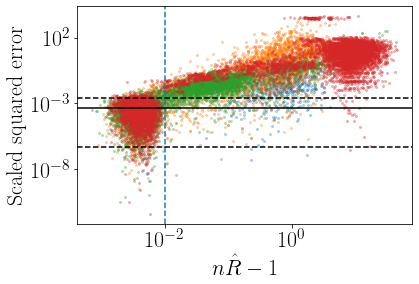

In [ ]:
alpha_point = 0.3
s_point = 4
eps = nRhat_upper - 1
eps_lower = nRhat_lower - 1
scatter(nRhat_banana - 1, err_banana, alpha = alpha_point, s = s_point)
scatter(nRhat_german - 1, err_german, alpha = alpha_point, s = s_point)
scatter(nRhat_schools - 1, err_schools, alpha = alpha_point, s = s_point)
scatter(nRhat_pk - 1, err_pk, alpha = alpha_point, s = s_point)
axvline(x = eps, linestyle = '--')
axhline(y = 1 / num_chains, color = 'black')
axhline(y = 5.023886 / num_chains, color = 'black', linestyle = '--')
axhline(y = 0.0009820691 / num_chains, color = 'black', linestyle = '--')
xscale('log')
yscale('log')
xlabel("$n \hat R - 1$")
ylabel("Scaled squared error")
show()

In [ ]:
def quadrant_counts (nRhat_array, err_array, nRhat_upper, chi_squared_uq):
  # For a given threshold, return the number of points that exceed an
  # expected threshold at stationarity, as specified by chi_squared_uq, 
  # under the assumption of stationarity (per the CLT).
  num_conv = sum(nRhat_array < nRhat_upper)
  num_nonconv = sum(nRhat_array > nRhat_upper)
  num_fp = sum((nRhat_array < nRhat_upper) & (err_array > chi_squared_uq))
  num_fn = sum((nRhat_array > nRhat_upper) & (err_array < chi_squared_uq))

  return np.array([num_fp / num_conv,
                   1 - num_fp / num_conv, 
                   num_fn / num_nonconv,
                   1 - num_fn / num_nonconv,
                   num_conv])

In [ ]:
print("chi_up:", chi_up)

chi_up: 3.841459


In [ ]:
chi_square_uq = chi_up / num_chains

nRhat_threshold = 1.1  # Warmup criteria is nRhat = 1.01

print(quadrant_counts(nRhat_banana, err_banana, nRhat_threshold, chi_square_uq))
print(quadrant_counts(nRhat_german, err_german, nRhat_threshold, chi_square_uq))
print(quadrant_counts(nRhat_schools, err_schools, nRhat_threshold, chi_square_uq))
print(quadrant_counts(nRhat_pk, err_pk, nRhat_threshold, chi_square_uq))


[9.84719864e-02 9.01528014e-01 1.68784029e-01 8.31215971e-01
 5.89000000e+02]
[2.38425926e-01 7.61574074e-01 3.01274623e-02 9.69872538e-01
 3.02400000e+03]
[4.96697490e-01 5.03302510e-01 2.93609672e-02 9.70639033e-01
 4.54200000e+03]
[2.03486529e-01 7.96513471e-01 5.18999073e-03 9.94810009e-01
 3.15500000e+03]


In [ ]:
# threshold_list = [1.001, 1.005, 1.01, 1.05, 1.1]
threshold_list = np.arange(1.0, 1.3, 0.001)
viol_banana = []
viol_german = []
viol_schools = []
viol_pk = []

count_banana = []
count_german = []
count_schools = []
count_pk = []

for i in threshold_list:
  quad_result = quadrant_counts(nRhat_banana, err_banana, i, chi_square_uq)
  viol_banana.append(quad_result[0])
  count_banana.append(quad_result[4])

  quad_result = quadrant_counts(nRhat_german, err_german, i, chi_square_uq)
  viol_german.append(quad_result[0])
  count_german.append(quad_result[4])

  quad_result = quadrant_counts(nRhat_schools, err_schools, i, chi_square_uq)
  viol_schools.append(quad_result[0])
  count_schools.append(quad_result[4])

  quad_result = quadrant_counts(nRhat_pk, err_pk, i, chi_square_uq)
  viol_pk.append(quad_result[0])
  count_pk.append(quad_result[4])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
epsilon = threshold_list
epsilon[:] = [number - 1.0 for number in threshold_list]


In [ ]:
# find first index with an acceptable number of observations
min_num_obs = 100
index_banana = next(x[0] for x in enumerate(count_banana) if x[1] > min_num_obs)
index_german = next(x[0] for x in enumerate(count_german) if x[1] > min_num_obs)
index_schools = next(x[0] for x in enumerate(count_schools) if x[1] > min_num_obs)
index_pk = next(x[0] for x in enumerate(count_pk) if x[1] > min_num_obs)


In [ ]:
matplotlib.rcParams.update({'font.size': 22})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

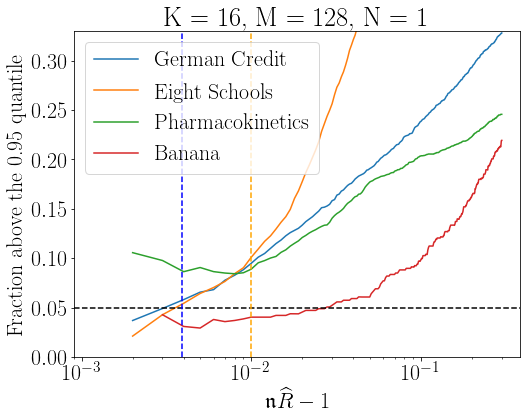

In [ ]:
fig = figure(figsize=(8, 6))
ax = axes()

ax.set_xscale('log')
ax.plot(epsilon[index_german:], viol_german[index_german:], label = "German Credit")
ax.plot(epsilon[index_schools:], viol_schools[index_schools:], label = "Eight Schools")
ax.plot(epsilon[index_pk:], viol_pk[index_pk:], label = "Pharmacokinetics")
ax.plot(epsilon[index_banana:], viol_banana[index_banana:], label = "Banana")

ax.axhline(y = 0.05, color = 'black', linestyle = '--')
if (num_samples == 5 or num_chains == 2048): ax.axvline(x = eps, color = 'orange', linestyle = '--')
if  (num_samples == 1): ax.axvline(x = eps_lower, color = 'blue', linestyle = '--')
ax.set_ylim(ymin=0, ymax = 0.33)
ax.set_xlim(xmin=9e-4)

if (num_chains == 2048 or num_super_chains == 2): ax.legend()
if (num_super_chains == 8): fig.text(0.0, 0.05, "Fraction above the 0.95 quantile",
                  rotation = "vertical", fontsize = 22)
if (num_chains == 2048): ylabel("Fraction above the 0.95 quantile")
if (num_chains == 2048): xlabel("$\mathfrak n \widehat R - 1$")
title("K = " + str(num_super_chains) + ", M = " + str(num_sub_chains) + ", N = " + str(num_samples))

filename = "fraction_" + "K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + ".pdf"
savefig(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

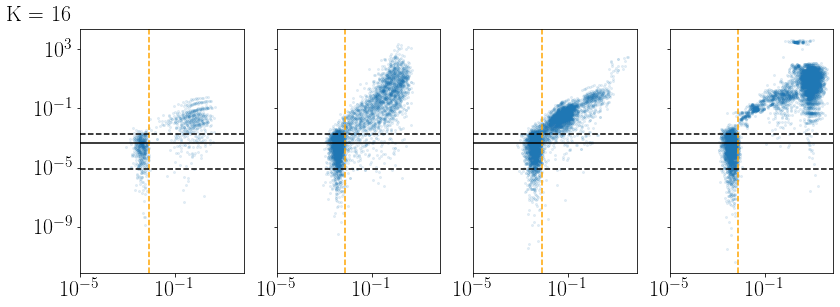

In [ ]:

# Do the same plot as above, but using a pannel
# alpha_point = 100
fig, ax = subplots(1, 4, sharey = True, sharex = True,
                   figsize=(13.5, 4.5))
ax[0].scatter(nRhat_banana - 1, err_banana,
              alpha = 0.1, s = s_point)
ax[1].scatter(nRhat_german - 1, err_german,
              alpha = 0.1, s = s_point)
ax[2].scatter(nRhat_schools - 1, err_schools,
              alpha = 0.1, s = s_point)
ax[3].scatter(nRhat_pk - 1, err_pk,
             alpha = 0.1, s = s_point)

for a in ax.flat:
    if False: a.set(ylabel='Scaled squared error')
    a.set_yscale('log')
    a.set_xscale('log')
    a.axvline(x = eps, linestyle = '--', color = 'orange')
    # a.axvline(x = eps_lower, linestyle = '--', color = 'blue')
    a.axhline(y = 1 / num_chains, color = 'black')
    a.axhline(y = chi_up / num_chains, color = 'black', linestyle = '--')
    a.axhline(y = chi_lo / num_chains, color = 'black', linestyle = '--')

# ax[1].set(xlabel='$n \hat R - 1$')

set_title = False

if set_title: 
  ax[0].set(title = "Banana")
  ax[1].set(title = "German Credit")
  ax[2].set(title = "Eight Schools")
  ax[3].set(title = "Pharmacokinetics")

xlim(left = 1e-5)
plot_title = "K = " + str(num_super_chains)
# plot_title = "K =" + str(num_super_chains) + ", M = " +\
#  str(num_chains // num_super_chains) + ", N = " + str(num_samples)
                                            
# title(plot_title)

if False: fig.text(0.5, 0.01, "$\mathfrak n \widehat R - 1$", ha='center', va='center')
fig.text(0.05, 0.9, plot_title)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

filename = "scatter_" + "K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + ".pdf"
savefig(filename)
files.download(filename)

In [ ]:
# For a given threshold, compute a histogram of the squared error.
eps = 1 / num_sub_chains
err_banana_eps = err_banana[nRhat_banana <= 1 + eps]
err_german_eps = err_german[nRhat_german <= 1 + eps]
err_schools_eps = err_schools[nRhat_schools <= 1 + eps]
err_pk_eps = err_pk[nRhat_pk <= 1 + eps]


In [ ]:
# chi square benchmark
err_chi2 = np.random.chisquare(df = 1, size = (100000, )) / num_chains

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

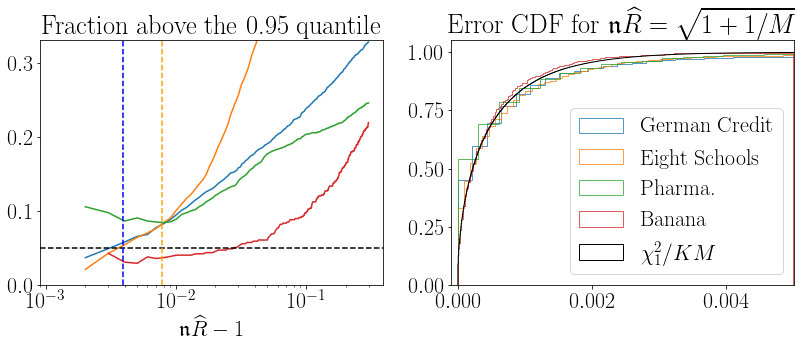

In [ ]:
fig, ax = subplots(1, 2, figsize=(13.5, 4.5))

ax[0].set_xscale('log')
ax[0].plot(epsilon[index_german:], viol_german[index_german:], label = "German Credit")
ax[0].plot(epsilon[index_schools:], viol_schools[index_schools:], label = "Eight Schools")
ax[0].plot(epsilon[index_pk:], viol_pk[index_pk:], label = "Pharmacokinetics")
ax[0].plot(epsilon[index_banana:], viol_banana[index_banana:], label = "Banana")

ax[0].axhline(y = 0.05, color = 'black', linestyle = '--')
ax[0].axvline(x = eps, color = 'orange', linestyle = '--')
if  True: ax[0].axvline(x = eps_lower, color = 'blue', linestyle = '--')
ax[0].set_ylim(ymin=0, ymax = 0.33)
ax[0].set_xlim(xmin=9e-4)

if False: ax[0].legend()
# if False: fig.text(0.0, 0.05, "Fraction above the 0.95 quantile",
#                   rotation = "vertical", fontsize = 22)
ax[0].set(title = "Fraction above the 0.95 quantile")
ax[0].set(xlabel = "$\mathfrak n \widehat R - 1$")
# if True: xlabel("$\mathfrak n \widehat R - 1$")
# title("K = " + str(num_super_chains) + ", M = " + str(num_sub_chains) + ", N = " + str(num_samples))

ax[1].hist(err_german_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'German Credit', alpha = 0.75)
ax[1].hist(err_schools_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'Eight Schools', alpha = 0.75)
ax[1].hist(err_pk_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'Pharma.', alpha = 0.75)
ax[1].hist(err_banana_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'Banana', alpha = 0.75)
ax[1].hist(err_chi2, histtype = "step", cumulative = True, density = True, bins = 2000, label = '$\chi^2_1 / KM$', color = 'black')
ax[1].legend(loc = "lower right")
ax[1].set_xlim(left = -0.0001, right = 0.005)
ax[1].set(title = "Error CDF for $\mathfrak n \widehat R = \sqrt{1 + 1 / M}$")

filename = "cdf_" + "K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + ".pdf"
savefig(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

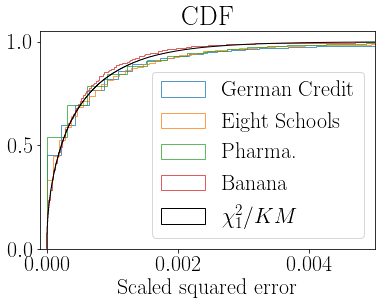

In [ ]:
figsize=(10, 10)
hist(err_german_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'German Credit', alpha = 0.75)
hist(err_schools_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'Eight Schools', alpha = 0.75)
hist(err_pk_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'Pharma.', alpha = 0.75)
hist(err_banana_eps, histtype="step", cumulative = True, density = True, bins = 200, label = 'Banana', alpha = 0.75)
hist(err_chi2, histtype = "step", cumulative = True, density = True, bins = 2000, label = '$\chi^2_1 / KM$', color = 'black')
legend(loc = "lower right")
xlim(left = -0.0001, right = 0.005)
# show()
title("CDF")
xlabel("Scaled squared error")

filename = "cdf_" + "K" + str(num_super_chains) + "_M" + str(num_sub_chains) + "_N" + str(num_samples) + ".pdf"
# savefig(filename)
# files.download(filename)

In [ ]:
len(err_banana_eps)

537

# Draft code

In [ ]:
nRhat, _B, _W = nested_rhat(mcmc_states,
                    num_super_chains, index_param, num_samples,
                    warmup_length = num_warmup,
                    state_is_list = True)

In [ ]:
seed = jax.random.PRNGKey(1954)

initial_state = initialize((num_super_chains,), key = seed)
initial_state = np.repeat(initial_state, num_chains // num_super_chains,
                          axis = 0)

result = tfp.mcmc.sample_chain(
      total_samples, initial_state, kernel = kernel,
      seed = seed)

np.mean(result.all_states[num_warmup:, :, :], axis = (0, 1))
# np.var(result.all_states[num_warmup:, :, :], axis = (0, 1))

In [ ]:
# Examine B and W
B_rescale = B_list / (2 * (nRhat_upper - 1))
fig = figure(figsize = (6, 2))
ax = fig.add_axes([0, 0, 1, 1])
plot_data = [B_rescale[:, 0], W_list[:, 0]]
ax.boxplot(plot_data, vert = 1)
ax.set_xticklabels(['B_rescale[0]', 'W[0]'])
axhline(y = var_est[0], linestyle = '--', linewidth = 0.5,
        label = "x = 1")
show()

initial_state = initialize((num_super_chains,), key = jax.random.PRNGKey(1954))
initial_state = np.repeat(initial_state, num_chains // num_super_chains,
                          axis = 0)

result = tfp.mcmc.sample_chain(
      total_samples, initial_state, kernel = kernel,
      seed = jax.random.PRNGKey(1954))

num_sub_chains = num_chains // num_super_chains
state_param = result.all_states[:, :, 0].reshape(total_samples, -1, num_sub_chains, 1)
mean_super_chain = np.mean(state_param, axis = (2, 3))
plot(mean_super_chain)
show()

B = np.var(mean_super_chain, axis = 1)
plot(B)
show()

In [ ]:
# Draft
result, num_windows = forge_chain(kernel_cold = kernel_cold,
                                  kernel_warm = kernel_warm,
                                  initial_state = initial_state,
                                  num_super_chains = num_super_chains,
                                  num_warmup = warmup_window,
                                  num_samples = num_samples,
                                  target_rhat = nRhat_upper,
                                  max_num_steps = 1000 // warmup_window,
                                  index_param = index_param,
                                  seed = seed)

# Theory (draft)

### Example A (Incomplete exploration)

In [ ]:
a = np.array(range(4, 1024, 4))
d = np.repeat(6., len(a))

# Two optimization solutions, solving quadratic equations (+ / -)
# Remark: + solution gives a negative upper-bound for delta_u
alpha_1 = 2 * a + d / 2 - np.sqrt(np.square(2 * a + d / 2) - 2 * a)
alpha_2 = a - alpha_1
delta_u = (np.square(alpha_1 + d / 2) / (alpha_1 * alpha_2)) / 2

eps = 0.01
delta = np.square(1 + eps) - 1

In [ ]:
semilogy(a / d, delta_u)
hlines(delta, (a / d)[0], (a / d)[len(a) - 1], linestyles = '--',
      label =  "delta for 1.01 threshold")
xlabel("a / d")

### Example B (Asymmetric binary initialization)

In [ ]:
alpha_l = 0.5  # options: 0.1, 0.5, 1.2
alpha_r = alpha_l

p =  np.arange(0., 1., 0.01)

sigma_pi = 1   # variance at stationarity

# upper bound on initial variance
stationary_bound = False
theta_0_l = 3
theta_0_r = 3 

conservative_bound = False
if conservative_bound:
  sigma_0 = np.power((theta_0_l + theta_0_r), 2) / 4
else:
  delta_L = (alpha_l / theta_0_l) * np.square(theta_0_l - alpha_l) +\
  (theta_0_l - alpha_l) * np.square(alpha_l)
  delta_R = (alpha_r / theta_0_r) * np.square(theta_0_r - alpha_r) +\
  (theta_0_r - alpha_r) * np.square(alpha_r)
  sigma_0 = p * delta_L + (1 - p) * delta_R
  # sigma_u = p * delta_L + (1 - p) * delta_R
  sigma_0 = delta_L  # (for now, assume symmetry)

if stationary_bound:
  sigma_u = sigma_pi
else:
  sigma_u = 2 * max(sigma_pi, sigma_0)


p = np.arange(0, 1.01, 0.01)     # prob of initializing on the left.

# Set bias for chains coming from the left and right
alpha_l = 1.2
alpha_r = alpha_l

delta = 0.02  # Relative tolerance for squared bias

In [ ]:
var_mc = p * (1 - p) * np.square(alpha_l + alpha_r)
bias_mc_squared = np.square(-p * alpha_l + (1 - p) * alpha_r)

rel_var = var_mc / sigma_u
rel_err = (var_mc + bias_mc_squared) /sigma_pi

In [ ]:
plot(p, var_mc + bias_mc_squared, label = "squared error")
plot(p, var_mc, label = "var_super")
legend(loc = "best")

In [ ]:
plot(p, rel_err, label = "rel_err")
plot(p, rel_var, label = "rel_var")
hlines(delta, 0, 1, linestyles = "--", label = "delta threshold")
legend(loc = "best")
xlabel("p")
title("alpha = " + str(alpha_l))